## Noisy RGB pixel only, Fit residual, L1 loss, 1/8 U-Net bottleneck

In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


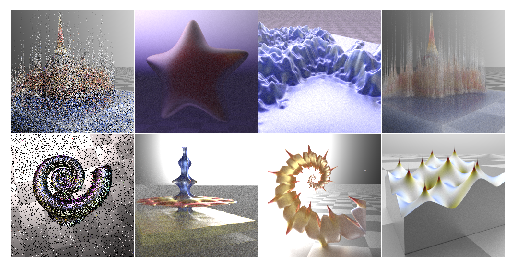

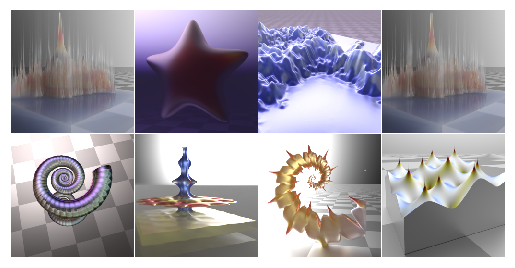

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
# plot_imgs(a[:, 0:3])
# plot_imgs(a[:, 3:6]*0.5+0.5)
# plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.econv0a = conv3(3, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1 = conv3(n0, n1) # 1/2
        self.econv2 = conv3(n1, n2) # 1/4
        self.mconv1 = conv3(n2, n3) # 1/8
        self.mconv2 = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv3(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv3(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv3(n0+n0, n0) # 1
        self.dconv0 = conv3(n0, 3) # 1

    def forward(self, input):
        e0 = self.econv0b(relu(self.econv0a(input))) # 1
        e1 = self.econv1(pool(e0)) # 1/2
        e2 = self.econv2(pool(e1)) # 1/4
        m1 = self.mconv1(pool(e2)) # 1/8
        m2 = self.mconv2(relu(m1)) # 1/8
        d2 = relu(self.dconv2a(relu(m2))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        d0 = relu(self.dconv0b(concat(d0, e0))) # 1
        return self.dconv0(d0)


model = Model().to(device)
print(model)

Model(
  (econv0a): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv1): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mconv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv0a): ConvTranspose2d(16, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv0b): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv0): Conv2d(12, 

128 0.03454278036952019
256 0.06523691862821579
384 0.02641543745994568
512 0.028173178434371948
640 0.028222516179084778
768 0.028756313025951385
896 0.01204589568078518
1024 0.020591696724295616
1152 0.014994360506534576
1280 0.012322703376412392
1408 0.033026356250047684
1536 0.02125575765967369
1664 0.018218688666820526
1792 0.01505250483751297
1920 0.018777329474687576
2048 0.014176181517541409
2176 0.012317637912929058
2304 0.018765324726700783
2432 0.014035291969776154
2560 0.013180459849536419
2688 0.018851768225431442
2816 0.016313429921865463
2944 0.015424404293298721
3072 0.02117987349629402
3200 0.01844922825694084
3328 0.017253093421459198
3456 0.023017611354589462
3584 0.012675049714744091
3712 0.011163653805851936
3840 0.010790752246975899
3968 0.009963050484657288
4096 0.010811964049935341


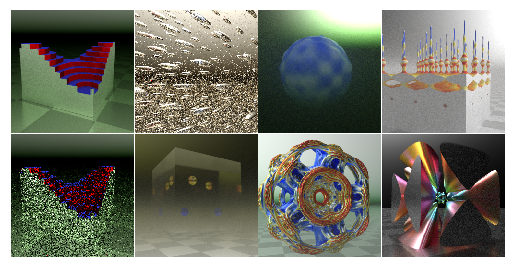

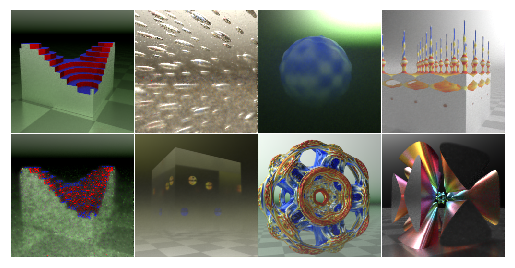

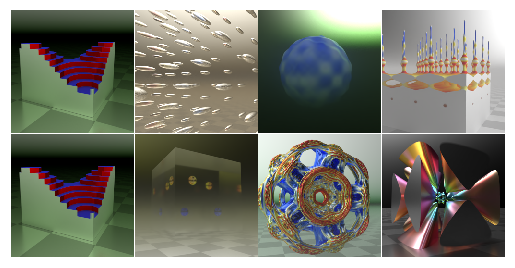

4224 0.010700265876948833
4352 0.012824641540646553
4480 0.008677145466208458
4608 0.013087837025523186
4736 0.010986551642417908
4864 0.019155925139784813
4992 0.013253515586256981
5120 0.008145011961460114
5248 0.008314280770719051
5376 0.012990688905119896
5504 0.007444304879754782
5632 0.016080986708402634
5760 0.010539300739765167
5888 0.018178705126047134
6016 0.011224868707358837
6144 0.018386241048574448
6272 0.01114245317876339
6400 0.01782350055873394
6528 0.008823556825518608
6656 0.010742477141320705
6784 0.006528473924845457
6912 0.006878515239804983
7040 0.007626666687428951
7168 0.01140102744102478
7296 0.010744067840278149
7424 0.010736510157585144
7552 0.013646054081618786
7680 0.006645211484283209
7808 0.014471102505922318
7936 0.005327689461410046
8064 0.007712619379162788
8192 0.007203112356364727


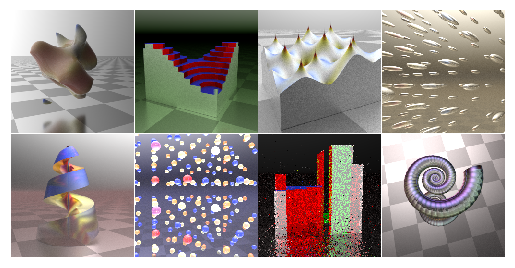

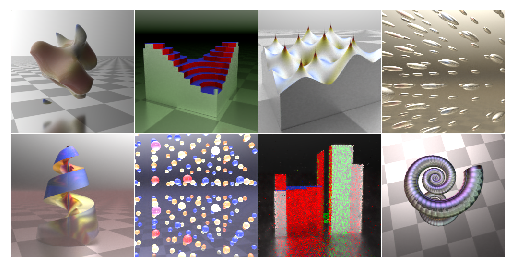

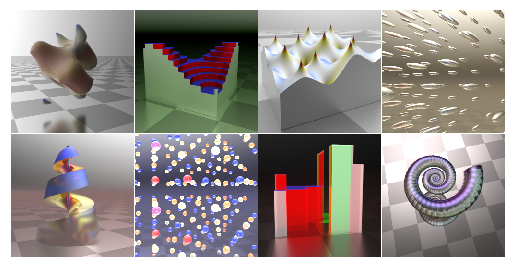

8320 0.01213171985000372
8448 0.008132120594382286
8576 0.015218844637274742
8704 0.009556942619383335
8832 0.0124085433781147
8960 0.008737423457205296
9088 0.01545841246843338
9216 0.012357950210571289
9344 0.006990298628807068
9472 0.0076692793518304825
9600 0.013135788962244987
9728 0.011962934397161007
9856 0.011851264163851738
9984 0.008505435660481453
10112 0.02265765890479088
10240 0.006139194592833519
10368 0.010506684891879559
10496 0.009085034020245075
10624 0.011541096493601799
10752 0.024349292740225792
10880 0.012262838892638683
11008 0.012765294872224331
11136 0.013948701322078705
11264 0.011304562911391258
11392 0.006060162093490362
11520 0.0075262924656271935
11648 0.006401603110134602
11776 0.005127277225255966
11904 0.012682376429438591
12032 0.006808191537857056
12160 0.005914961453527212
12288 0.008497055619955063


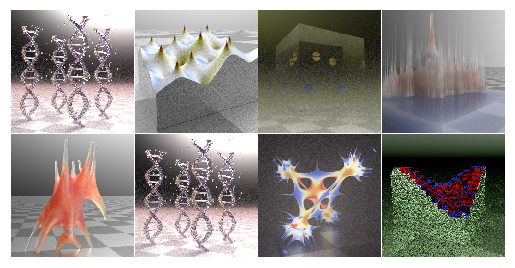

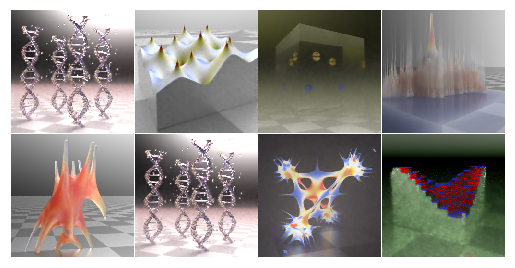

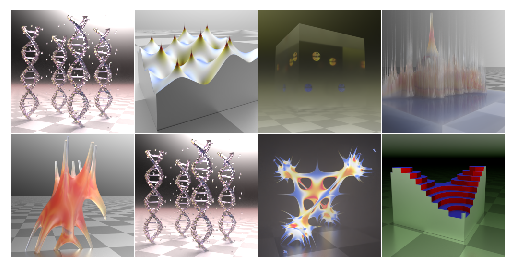

12416 0.012666965834796429
12544 0.01244024746119976
12672 0.011191765777766705
12800 0.010287688113749027
12928 0.010640534572303295
13056 0.005712938494980335
13184 0.009145690128207207
13312 0.006411104463040829
13440 0.017126377671957016
13568 0.0164615660905838
13696 0.008360477164387703
13824 0.024497784674167633
13952 0.013053646311163902
14080 0.010033891536295414
14208 0.006911817006766796
14336 0.011061770841479301
14464 0.012388109229505062
14592 0.00892031192779541
14720 0.009050760418176651
14848 0.010755399242043495
14976 0.005652415566146374
15104 0.011441494338214397
15232 0.011794771067798138
15360 0.00624867295846343
15488 0.01038279291242361
15616 0.010599578730762005
15744 0.00919643510133028
15872 0.014893487095832825
16000 0.009771718643605709
16128 0.004230852238833904
16256 0.007161030080169439
16384 0.0064583467319607735


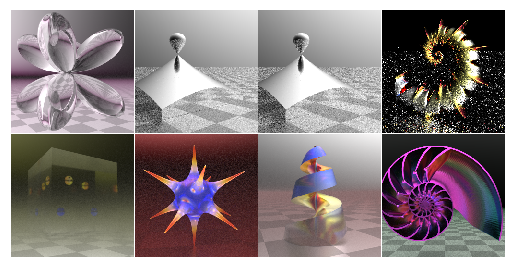

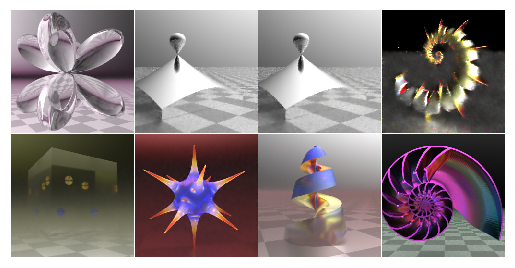

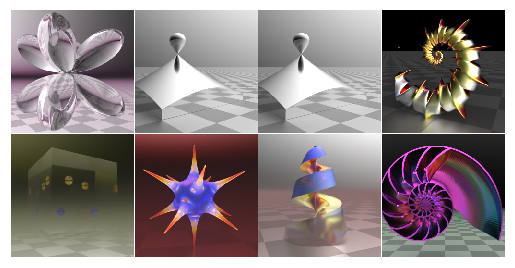

16512 0.009197544306516647
16640 0.004930439870804548
16768 0.006440531462430954
16896 0.008432449772953987
17024 0.009908171370625496
17152 0.011241031810641289
17280 0.014358868822455406
17408 0.006078864447772503
17536 0.01221800409257412
17664 0.0065857721492648125
17792 0.009117869660258293
17920 0.007410715334117413
18048 0.01502826064825058
18176 0.009044433012604713
18304 0.00531681627035141
18432 0.010582232847809792
18560 0.006399950012564659
18688 0.011241383850574493
18816 0.012248832732439041
18944 0.012962746433913708
19072 0.01037383358925581
19200 0.015127824619412422
19328 0.012475768104195595
19456 0.008040356449782848
19584 0.014490618370473385
19712 0.009231839329004288
19840 0.014956368133425713
19968 0.0036220047622919083
20096 0.021237758919596672
20224 0.0062599885277450085
20352 0.005226615816354752
20480 0.006353065371513367


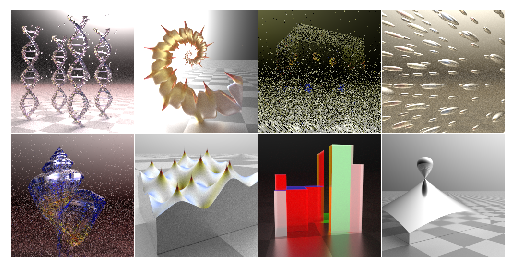

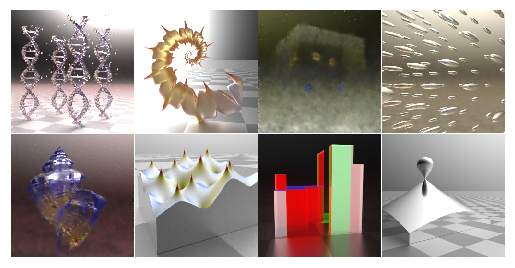

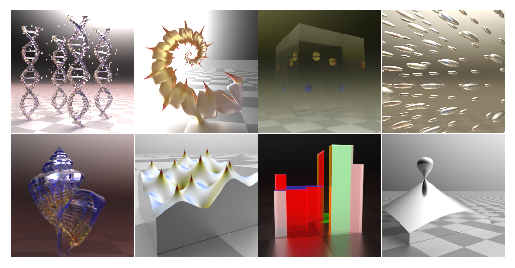

20608 0.006196626927703619
20736 0.004509276244789362
20864 0.011790303513407707
20992 0.009799500927329063
21120 0.0075256782583892345
21248 0.005694645922631025
21376 0.0085872458294034
21504 0.004488972015678883
21632 0.00652008643373847
21760 0.006558417342603207
21888 0.007296331226825714
22016 0.0036030374467372894
22144 0.007773864082992077
22272 0.004722714424133301
22400 0.0065968893468379974
22528 0.011120392009615898
22656 0.013358469121158123
22784 0.009563125669956207
22912 0.010926490649580956
23040 0.011277823708951473
23168 0.010135739110410213
23296 0.010216917842626572
23424 0.006950712762773037
23552 0.009116249158978462
23680 0.011897969990968704
23808 0.009398899972438812
23936 0.011238059028983116
24064 0.013988683931529522
24192 0.012009824626147747
24320 0.013116134330630302
24448 0.0038406657986342907
24576 0.008496689610183239


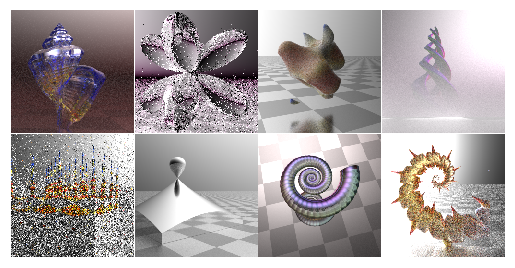

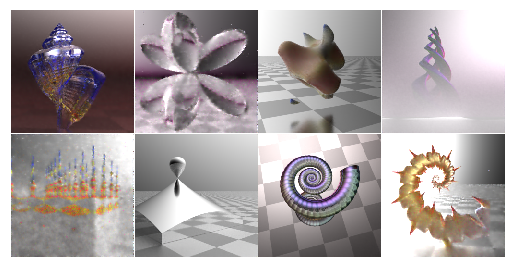

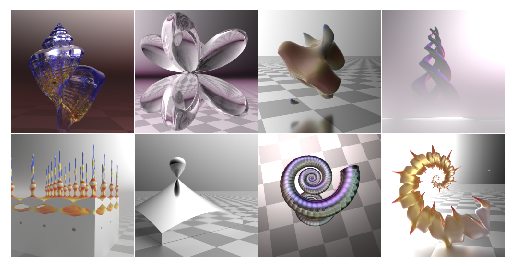

24704 0.006526322569698095
24832 0.00453600799664855
24960 0.00721046281978488
25088 0.005887187086045742
25216 0.0049456520937383175
25344 0.007094298489391804
25472 0.006351762916892767
25600 0.013998850248754025
25728 0.006265541072934866
25856 0.0077565861865878105
25984 0.005328137427568436
26112 0.006770809646695852
26240 0.006272341590374708
26368 0.0043780202977359295
26496 0.016364648938179016
26624 0.012441866099834442
26752 0.004660884849727154
26880 0.01259639672935009
27008 0.00908813439309597
27136 0.008795738220214844
27264 0.012259739451110363
27392 0.004763961769640446
27520 0.005590715445578098
27648 0.0059900651685893536
27776 0.009823009371757507
27904 0.010927675291895866
28032 0.005397334694862366
28160 0.0030214141588658094
28288 0.0070853508077561855
28416 0.01039018202573061
28544 0.00924227386713028
28672 0.009483175352215767


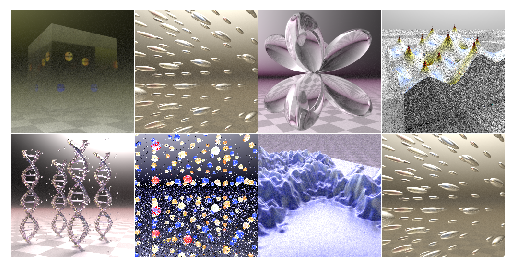

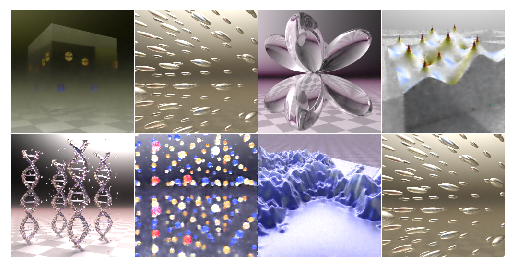

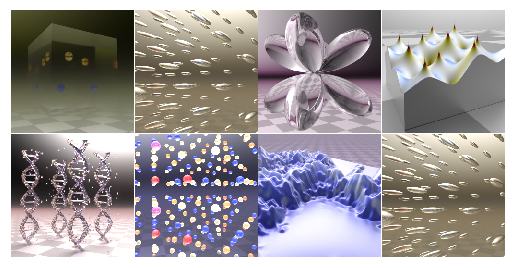

28800 0.007612243294715881
28928 0.008685989305377007
29056 0.006304411217570305
29184 0.009998760186135769
29312 0.012203523889183998
29440 0.0073362234979867935
29568 0.009757887572050095
29696 0.008541831746697426
29824 0.025730034336447716
29952 0.005669116973876953
30080 0.016408251598477364
30208 0.02255331724882126
30336 0.006790512707084417
30464 0.008445585146546364
30592 0.007686878554522991
30720 0.007158202584832907
30848 0.00497224647551775
30976 0.005582792218774557
31104 0.009814620018005371
31232 0.01598292961716652
31360 0.015575414523482323
31488 0.004661675076931715
31616 0.009740286506712437
31744 0.00815670471638441
31872 0.00748613104224205
32000 0.009137546643614769
32128 0.004893608391284943
32256 0.010652616620063782
32384 0.011388232931494713
32512 0.009687701240181923
32640 0.005603998899459839
32768 0.009834280237555504


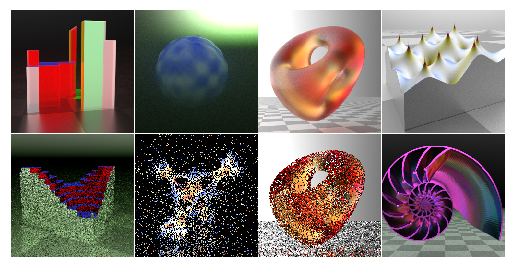

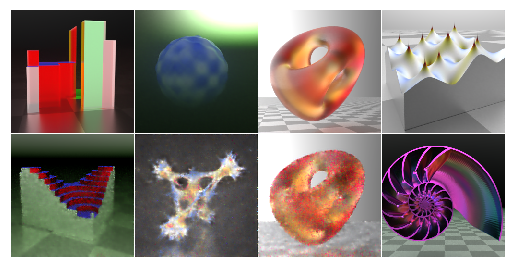

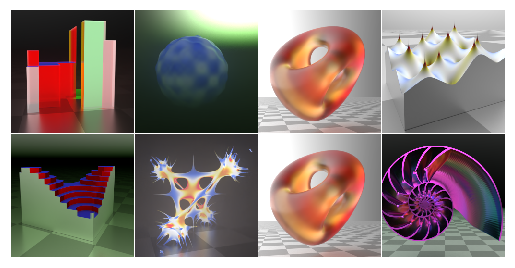

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001
    # lr = 0.00001
)

def lossfun(output, reference):
    return torch.mean(torch.abs(output-reference))

model_params = torch.cat([x.view(-1) for x in model.parameters()])

batch_count = 0
for epoch in range(2):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        # x = torch.pow(x, 2.2)
        # y = torch.pow(y, 2.2)
        optimizer.zero_grad()
        output = model(x)
        torch.mean(torch.abs(output))
        loss = lossfun(output, y-x)
        # regl1 = 0.1 * torch.mean(torch.abs(model_params))
        # regl2 = 0.1 * torch.mean(torch.abs(model_params))
        # (loss+regl1+regl2).backward()
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 128 == 0:
            print(batch_count, loss.item())
        if batch_count % 4096 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp((output+x).detach())-1)
            plot_imgs(torch.exp(y)-1)
            # plot_imgs(torch.pow(x, 1.0/2.2))
            # plot_imgs(torch.pow(torch.clip(output+x,0.0,1.0).detach(), 1.0/2.2))
            # plot_imgs(torch.pow(y, 1.0/2.2))


In [6]:
torch.save(model, "model3c_small.pth")